# 尤度関数と確率関数の違いは何なのか？

PRMLでは尤度は確率だが確率分布ではないと述べている。

> 観測データが生じる確率である尤度関数は
> （中略）
> 。尤度関数は$p(x|\mu)$は$\mu$上の確率分布ではなく、正規化もされていないことを、もう一度強調しておく。
>
> （C.M.ビショップ（2012）『パターン認識と機械学習 上』丸善出版、p.95。）

ただ、最尤推定の手続きを見ていると、（対数を取る前の）尤度は（i.i.d.を仮定できるときの）同時確率と相違ないように見える。

どういうことなのか？

## 最尤推定の流れと同時確率の確認

今一度最尤推定を振り返る。

例として、ある県に住む男性の身長の分布を調べたいとする。身長を平均$\mu$、分散$\sigma^2$の正規分布に従う確率変数$x \sim N(\mu, \sigma^2)$とみなして（仮定して・モデリングして）扱うこととする。

手元にランダム・サンプリングした10人分のデータがあり、次のようになっていたとする。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n = 10
mu = 170
sigma2 = 25
sigma = np.sqrt(sigma2)

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=n).astype(int)
df = pd.DataFrame({"x": x})
df

,x
0,178
1,172
2,174
3,181
4,179
5,165
6,174
7,169
8,169
9,172


### 同時確率関数

10人のデータをとったとして、その組み合わせのデータが得られる確率（同時確率）は、データが独立同分布（i.i.d.）に従うと仮定すると、確率の独立性から同時確率は確率の積

$$
\begin{align}
P(x_1, x_2, \cdots, x_{10}|\mu, \sigma^2)
&= P(x_1|\mu, \sigma^2) P(x_2|\mu, \sigma^2) \cdots P(x_{10}|\mu, \sigma^2)
\\
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
\end{align}
$$

と書くことができる。

パラメータは未知だが、仮に$\mu = 170, \sigma^2 = 25$とすると、上記の10人の個々の$x$に対応する確率$P(x|\mu, \sigma^2)$は以下の表の`p(x)`列のようになる。


In [2]:
from scipy.stats import norm

df.loc[:, "p(x)"] = norm.pdf(df["x"], loc=mu, scale=sigma)
df

,x,p(x)
0,178,0.022184
1,172,0.073654
2,174,0.057938
3,181,0.007095
4,179,0.015790
5,165,0.048394
6,174,0.057938
7,169,0.078209
8,169,0.078209
9,172,0.073654


In [3]:
from myst_nb import glue
glue("joint_proba", df["p(x)"].product())

1.3396747297828266e-14

これらの積（同時確率）は{glue:}`joint_proba`となる。

#### プロット

パラメータの値を変えつつ確率を計算して分布を描くと次の図のようになる

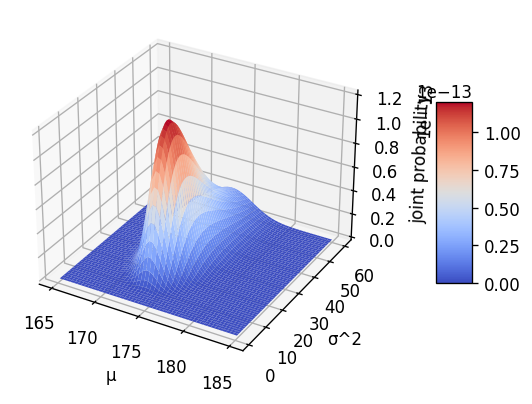

In [4]:
def joint_proba(x, loc: float, scale: float) -> float:
    probabilities = norm.pdf(x, loc=loc, scale=scale)
    return pd.Series(probabilities).product()

# 3d plot
mu_range = np.linspace(165, 185, 50)
sigma2_range = np.linspace(1, 60, 60)

Mu, Sigma2 = np.meshgrid(mu_range, sigma2_range)
Proba = np.array([joint_proba(df["x"], loc=_mu, scale=np.sqrt(_sigma2)) for _mu, _sigma2 in zip(Mu.flatten(), Sigma2.flatten())]).reshape(Mu.shape)

from matplotlib import cm
fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Mu, Sigma2, Proba, rstride=1, cstride=1, linewidth=1, antialiased=True, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.11)

ax.set(xlabel="μ", ylabel="σ^2", zlabel="joint probability")
fig.show()

### 尤度関数

上記のデータが観測される確率が最も高いパラメータ$\mu, \sigma^2$を考えたい。

やりたいこととしては上記の同時確率を最大化するパラメータを求めることに相当する。

#### 解析的に解く

計算の簡単のため尤度関数

$$
L(\mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
$$


の対数をとると、対数尤度は

$$
\log L(\mu, \sigma^2)
= - \frac{n}{2} \log (2\pi)
- \frac{n}{2} \log \sigma^2
- \frac{1}{2\sigma^2} \sum^n_{i=1} (x_i - \mu)^2
$$

となる。

::::{admonition} 導出メモ
:class: dropdown

まず尤度を軽く整理する

$$
\begin{align}
L(\mu, \sigma^2)
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}}
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
\\
&= \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)^n
\prod_{i=1}^n
\exp \left \{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right \}
\end{align}
$$

対数をとると

$$
\begin{align}
\ln L(\mu, \sigma^2)
&= n \ln \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)
+ \sum^n_{i=1} \ln \left(
\exp \left\{ - \frac{(x_i - \mu)^2}{2\sigma^2} \right\}
\right)
\\
&= n \ln (1) - n \ln (\sqrt{2\pi\sigma^2})
+ \sum^n_{i=1} \left(
- \frac{(x_i - \mu)^2}{2\sigma^2}
\ln e
\right)
\\
&= - n \ln (\sqrt{2\pi\sigma^2})
- \sum^n_{i=1} \frac{(x_i - \mu)^2}{2\sigma^2}
\\
&= - \frac{n}{2} \ln (2\pi)
- \frac{n}{2} \ln \sigma^2
- \frac{1}{2\sigma^2} \sum^n_{i=1} (x_i - \mu)^2
\end{align}
$$


:::{card}
（参考）対数の公式

$$
\begin{align}
\log 1 &= 0\\
\log_e e &= 1\\
\log x^a &= a\log x\\
\log \sqrt{a} &= \log a^{1/2} = \textstyle \frac{1}{2} \log a\\
\log ab &= \log a + \log b\\
\log \frac{a}{b} &= \log a - \log b
\end{align}
$$
:::
::::

これを解くと

$$
\begin{align}
\frac{\partial \log L}{\partial \mu}
&= - \frac{1}{\sigma^2} \sum_{n=1}^n (x_i - \mu) = 0
\\
\frac{\partial \log L}{\partial \sigma^2}
&= - \frac{n}{2\sigma^2}
+ \frac{1}{2\sigma^4} \sum_{n=1}^n (x_i - \mu)^2 = 0
\end{align}
$$

から

$$
\begin{align}
\hat{\mu} &= \bar{x} = \frac{1}{n} \sum^n_{i=1} x_i\\
\hat{\sigma}^2 &=  \frac{1}{n} \sum^n_{i=1} (x_i - \bar{x})^2
\end{align}
$$

となる。

#### プロット

同時確率のグラフに最尤推定値をプロットすると次のようになる。

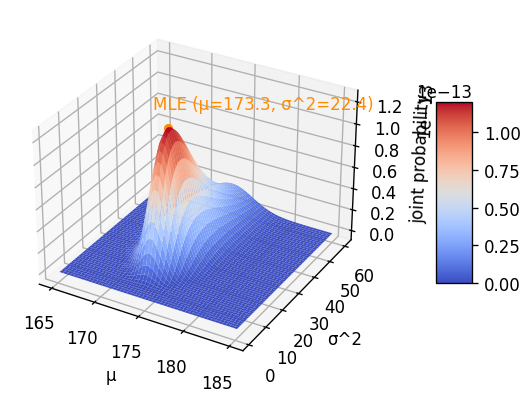

In [5]:
# plot
fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Mu, Sigma2, Proba, rstride=1, cstride=1, linewidth=1, antialiased=True, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.11)
ax.set(xlabel="μ", ylabel="σ^2", zlabel="joint probability")

# maximum likelihood estimates
mu_hat = df["x"].sum() / n
sigma2_hat = ((df["x"] - mu_hat)**2).sum() / n
p_hat = joint_proba(df["x"], loc=mu_hat, scale=np.sqrt(sigma2_hat))
# add a point
ax.scatter(mu_hat, sigma2_hat, p_hat, color="darkorange")
ax.text(mu_hat * 0.99, sigma2_hat, p_hat * 1.1, f"MLE (μ={mu_hat:.1f}, σ^2={sigma2_hat:.1f})", color="darkorange")

fig.show()

なお、同時確率を対数変換して対数尤度にすると次のようになる

/home/mitama/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:124: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


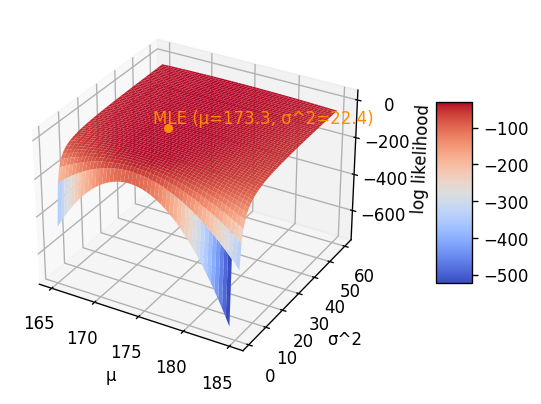

In [133]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # plot
    fig, ax = plt.subplots(dpi=120, subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(Mu, Sigma2, np.log(Proba), rstride=1, cstride=1, linewidth=1, antialiased=True, cmap=cm.coolwarm)
    fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.11)
    ax.set(xlabel="μ", ylabel="σ^2", zlabel="log likelihood")

    # add a MLE point
    ax.scatter(mu_hat, sigma2_hat, p_hat, color="darkorange")
    ax.text(mu_hat * 0.99, sigma2_hat, p_hat * 1.1, f"MLE (μ={mu_hat:.1f}, σ^2={sigma2_hat:.1f})", color="darkorange")

    fig.show()

## 書籍ごとの説明

PRML以外ではどう書かれているか？


**『統計学入門』**

> ここでわれわれが採用する原理は**最尤原理** principle of maximum likelihoodといわれ「現実の標本は確率最大のものが実現した」という仮定である。すなわち、この標本が得られる確率は （中略） このようにもっともらしさを**尤度** likelihood、その関数を**尤度関数** likelihood functionと呼ぶ。
>
> （東京大学教養学部統計学教室 編（1991）『統計学入門』東京大学出版会、p.217）


**『現代数理統計学の基礎』**

> $\boldsymbol{X} = (X_1, ..., X_n)$の同時確率関数もしくは同時確率密度関数において$\boldsymbol{x}$を$\boldsymbol{X}$に置き換えたものを （中略）と書き、**尤度関数**（likelihood function）という。
>
> （久保川達也（2017）『現代数理統計学の基礎』共立出版、p.121）


**『はじめての統計データ分析』**

> 母数を変数として扱い、データを定数として確率密度関数を扱った場合には、同じ式を**尤度**（likelihood）と呼びます。
>
> （豊田秀樹（2016）『はじめての統計データ分析: ベイズ的ポスト p 値時代の統計学』朝倉書店、p.17）

**『基礎からのベイズ統計学』**

> この式を$x$の関数と見たときが確率です。同じ式を$\theta$の関数と見たときが尤度です。$x$について（確率について）足し上げると1になりましたが、$\theta$について（尤度について）積分しても1になりません。
>
> （豊田秀樹（2015）『基礎からのベイズ統計学: ハミルトニアンモンテカルロ法による実践的入門』朝倉書店、p.41）


## 足し上げたとき1になるかどうか

同時確率密度関数$P(x, y|\theta)$を$x, y$について足し上げたものは

$$
\int_{-\infty}^{+\infty}
\int_{-\infty}^{+\infty}
P(x, y | \theta) dx dy = 1
$$

であり、尤度を$\theta$について足し上げたものは

$$
\int_{-\infty}^{+\infty}
P(x, y|\theta) d\theta \neq 1
$$

であるというのが違いらしい。

### 例：二項分布

$Binomial(k, n=10, p=0.5)$の二項分布の場合、同時確率は次のようになる

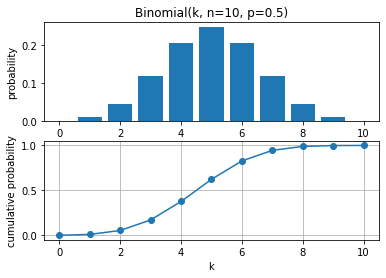

In [112]:
import numpy as np
from scipy.stats import binom

# 二項分布：n回試行してk回成功する確率
n = 10
p = 0.5

K = range(0, 11)
pmfs = [binom.pmf(k, n, p) for k in K]
cdfs = [binom.cdf(k, n, p) for k in K]
# cdfs = [sum(pmfs[:i+1]) for i in range(n + 1)]  # ほぼ同じだけどやや不正確かも

fig, axes = plt.subplots(nrows=2)
xlim = [-0.5, 10.5]
axes[0].bar(K, pmfs)
axes[0].set(ylabel="probability", title="Binomial(k, n=10, p=0.5)", xlim=xlim)
axes[1].plot(K, cdfs, marker="o")
axes[1].set(xlabel="k", ylabel="cumulative probability", xlim=xlim)
axes[1].grid(True)
fig.show()

累積分布からもわかるように、その合計は

$$
\sum^n_{k=1} P(k|n, p) = 1
$$

となっている。

今度は$k=5$というデータが得られていて$p$が未知の状況を仮定したときの尤度を見てみる。尤度を描いたものが次の図で、横軸は$k$ではなく$p$となっている。下の図は数値積分によって累積分布関数のようなもの（$k$についての積分ではなく$p$についての積分なので異なる）を計算したもの。

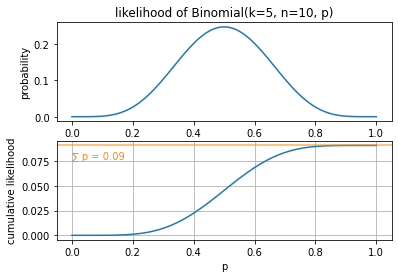

In [128]:
from scipy import integrate
k = 5
n = 10
n_split = 101

fig, axes = plt.subplots(nrows=2)
P = np.linspace(0, 1, n_split)
pmfs = [binom.pmf(k, n, p) for p in P]
# cdfs = [binom.cdf(k, n, p) for p in P]
# cdfs = [sum(pmfs[:i+1]) / n_split for i in range(len(pmfs))]
# 台形公式 (trapezoidal rule) による数値積分
cdfs = [integrate.trapezoid(pmfs[:i+1], P[:i+1]) for i in range(len(pmfs))]

axes[0].plot(P, pmfs)
axes[0].set(ylabel="probability", title="likelihood of Binomial(k=5, n=10, p)")
axes[1].plot(P, cdfs)
axes[1].set(xlabel="p", ylabel="cumulative likelihood")

axes[1].axhline(cdfs[-1], color="darkorange", alpha=0.7)
axes[1].text(0, cdfs[-1] * 0.85, f"∑ p = {cdfs[-1]:.2f}", color="darkorange")

axes[1].grid(True)

fig.show()

図からもわかるように、

$$
\int_0^1 P(k|n, p) dp
$$

は1にはなっていない

## 結論

同時確率と尤度は関数は同じであり、**関数の個別の出力自体は同じもの**。

だが、引数のなにが定数でなにが変数であるかが異なる。それにより、**総和や積分が変わってくる**。

同時確率関数$f(x|\theta)$は定義より

$$
\sum^{\infty}_{i=1} f(x_i|\theta) = 1
$$

あるいは同時確率密度関数の場合は

$$
\int^{\infty}_{-\infty} f(x|\theta) dx = 1
$$

となり、確率の定義を満たす。

（というより、確率の定義を満たすように設計した関数となっている。例えば正規分布の$\frac{1}{\sqrt{2\pi}\sigma}$はそのための正規化定数）

尤度の場合は$x$が定数で$\theta$が変数であるため積分する場合は

$$
\int^{\infty}_{-\infty} f(x|\theta) d \theta
$$


となるため1になるとは限らず、**尤度は確率の定義を満たさない**。